In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [46]:
# load data
raw_df = pd.read_csv('Dataset/train_data.csv')
raw_df.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [47]:
# Shape
raw_df.shape

(109248, 17)

In [48]:
# null values
raw_df.isna().sum()/len(raw_df)

Unnamed: 0                                      0.000000
id                                              0.000000
teacher_id                                      0.000000
teacher_prefix                                  0.000027
school_state                                    0.000000
project_submitted_datetime                      0.000000
project_grade_category                          0.000000
project_subject_categories                      0.000000
project_subject_subcategories                   0.000000
project_title                                   0.000000
project_essay_1                                 0.000000
project_essay_2                                 0.000000
project_essay_3                                 0.965601
project_essay_4                                 0.965601
project_resource_summary                        0.000000
teacher_number_of_previously_posted_projects    0.000000
project_is_approved                             0.000000
dtype: float64

In [49]:
raw_df.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [50]:
raw_df.drop(['Unnamed: 0', 'id', 'teacher_id', 'project_submitted_datetime',],axis=1,inplace=True)

In [51]:
raw_df.isna().sum()

teacher_prefix                                       3
school_state                                         0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

In [52]:
raw_df.drop(columns=['project_essay_3','project_essay_4'],axis=1,inplace=True)
raw_df.dropna(inplace=True)

In [53]:
raw_df.isna().sum()

teacher_prefix                                  0
school_state                                    0
project_grade_category                          0
project_subject_categories                      0
project_subject_subcategories                   0
project_title                                   0
project_essay_1                                 0
project_essay_2                                 0
project_resource_summary                        0
teacher_number_of_previously_posted_projects    0
project_is_approved                             0
dtype: int64

In [54]:
raw_df.shape

(109245, 11)

In [55]:
import re
import string
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text):
    """
    Cleans the text by removing punctuation, converting to lowercase,
    tokenizing, and removing stopwords.

    Args:
        text (str): The text to clean.

    Returns:
        str: The cleaned text.
    """
    stop_words = set(stopwords.words('english'))
    # Remove punctuation and symbols
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def preprocess_and_save_tfidf(df, text_columns, max_features=100, output_file="tfidf_model.pkl"):
    """
    Preprocesses multiple text columns, applies TF-IDF, and saves the transformer.

    Args:
        df (pd.DataFrame): The DataFrame containing the text columns.
        text_columns (list): List of text column names to preprocess.
        max_features (int): Maximum features for TF-IDF representation.
        output_file (str): File name to save the TF-IDF transformer.

    Returns:
        pd.DataFrame: DataFrame with concatenated TF-IDF features.
    """
    tfidf_features_list = []
    tfidf_transformers = {}

    for col in text_columns:
        # Clean and preprocess the column
        df[col] = df[col].fillna('').apply(clean_text)
        
        # Apply TF-IDF
        tfidf = TfidfVectorizer(max_features=max_features)
        tfidf_matrix = tfidf.fit_transform(df[col])
        
        # Store the TF-IDF transformer for the column
        tfidf_transformers[col] = tfidf
        
        # Convert to DataFrame and rename columns for clarity
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"{col}_{word}" for word in tfidf.get_feature_names_out()])
        tfidf_features_list.append(tfidf_df)
    
    # Combine all TF-IDF features into a single DataFrame
    combined_tfidf = pd.concat(tfidf_features_list, axis=1)
    
    # Save the TF-IDF transformers
    with open(output_file, "wb") as file:
        pickle.dump(tfidf_transformers, file)
    
    return combined_tfidf



# Preprocess multiple columns and save TF-IDF transformers
text_columns = ['project_title', 'project_essay_1', 'project_essay_2', 'project_resource_summary']
tfidf_features = preprocess_and_save_tfidf(raw_df, text_columns, max_features=100, output_file="tfidf_transformers.pkl")

[nltk_data] Downloading package punkt to /Users/yuvraj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuvraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
tfidf_features.shape

(109245, 400)

In [57]:
tfidf_features.head()

,project_title_21st,project_title_active,project_title_art,project_title_book,project_title_books,project_title_building,project_title_center,project_title_century,project_title_chromebooks,project_title_class,...,project_resource_summary_two,project_resource_summary_use,project_resource_summary_variety,project_resource_summary_way,project_resource_summary_well,project_resource_summary_wobble,project_resource_summary_work,project_resource_summary_world,project_resource_summary_writing,project_resource_summary_year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.587345,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
raw_df.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,Mrs.,IN,Grades PreK-2,Literacy & Language,"ESL, Literacy",educational support english learners home,students english learners working english seco...,limits language limits worldludwig wittgenstei...,students need opportunities practice beginning...,0,0
1,Mr.,FL,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",wanted projector hungry learners,students arrive school eager learn polite gene...,projector need school crucial academic improve...,students need projector help viewing education...,7,1
2,Ms.,AZ,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",soccer equipment awesome middle school students,rntrue champions arent always ones win guts mi...,students campus come school knowing face uphil...,students need shine guards athletic socks socc...,1,0
3,Mrs.,KY,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",techie kindergarteners,work unique school filled esl english second l...,students live high poverty conditions limited ...,students need engage reading math way inspire ...,4,1
4,Mrs.,TX,Grades PreK-2,Math & Science,Mathematics,interactive math tools,second grade classroom next year made around 2...,many students math subject pertain life subjec...,students need hands practice mathematics fun p...,1,1


In [59]:
import pandas as pd
import pickle

def one_hot_encode_and_save(df, categorical_columns, output_file="one_hot_encoder.pkl"):
    """
    Converts categorical columns into one-hot encoding and saves the transformer.

    Args:
        df (pd.DataFrame): DataFrame containing the categorical columns.
        categorical_columns (list): List of column names to one-hot encode.
        output_file (str): Path to save the one-hot encoder as a pickle file.

    Returns:
        pd.DataFrame: DataFrame with one-hot encoded features.
    """
    try:
        # Perform one-hot encoding
        one_hot_encoded_df = pd.get_dummies(df[categorical_columns], drop_first=True)

        # Save the transformed data to a .pkl file
        print(f"Saving one-hot encoded data to: {output_file}")
        with open(output_file, "wb") as file:
            pickle.dump(one_hot_encoded_df, file)
        
        print("One-hot encoding saved successfully!")
        return one_hot_encoded_df
    
    except Exception as e:
        print(f"An error occurred during one-hot encoding: {e}")
        return pd.DataFrame()


# Specify categorical columns
categorical_columns = ['project_subject_categories']

# One-hot encode and save to a .pkl file
one_hot_encoded_df = one_hot_encode_and_save(raw_df, categorical_columns, output_file="one_hot_encoded.pkl")

# Display the resulting DataFrame
one_hot_encoded_df.head()

Saving one-hot encoded data to: one_hot_encoded.pkl
One-hot encoding saved successfully!


,"project_subject_categories_Applied Learning, Health & Sports","project_subject_categories_Applied Learning, History & Civics","project_subject_categories_Applied Learning, Literacy & Language","project_subject_categories_Applied Learning, Math & Science","project_subject_categories_Applied Learning, Music & The Arts","project_subject_categories_Applied Learning, Special Needs","project_subject_categories_Applied Learning, Warmth, Care & Hunger",project_subject_categories_Health & Sports,"project_subject_categories_Health & Sports, Applied Learning","project_subject_categories_Health & Sports, History & Civics",...,"project_subject_categories_Music & The Arts, Applied Learning","project_subject_categories_Music & The Arts, Health & Sports","project_subject_categories_Music & The Arts, History & Civics","project_subject_categories_Music & The Arts, Special Needs","project_subject_categories_Music & The Arts, Warmth, Care & Hunger",project_subject_categories_Special Needs,"project_subject_categories_Special Needs, Health & Sports","project_subject_categories_Special Needs, Music & The Arts","project_subject_categories_Special Needs, Warmth, Care & Hunger","project_subject_categories_Warmth, Care & Hunger"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
one_hot_encoded_df.shape

(109245, 50)

In [61]:
raw_df.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [62]:
df = raw_df.copy()

In [63]:
df.drop(columns=['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2', 'project_resource_summary'],axis=1,inplace=True)

In [64]:
df.shape

(109245, 2)

In [65]:
df.head()

,teacher_number_of_previously_posted_projects,project_is_approved
0,0,0
1,7,1
2,1,0
3,4,1
4,1,1


In [66]:
final_df = pd.concat([df, tfidf_features, one_hot_encoded_df],axis=1)

In [67]:
final_df.shape

(109248, 452)

In [68]:
final_df.isna().sum()

teacher_number_of_previously_posted_projects                       3
project_is_approved                                                3
project_title_21st                                                 3
project_title_active                                               3
project_title_art                                                  3
                                                                  ..
project_subject_categories_Special Needs                           3
project_subject_categories_Special Needs, Health & Sports          3
project_subject_categories_Special Needs, Music & The Arts         3
project_subject_categories_Special Needs, Warmth, Care & Hunger    3
project_subject_categories_Warmth, Care & Hunger                   3
Length: 452, dtype: int64

In [69]:
final_df.head()

,teacher_number_of_previously_posted_projects,project_is_approved,project_title_21st,project_title_active,project_title_art,project_title_book,project_title_books,project_title_building,project_title_center,project_title_century,...,"project_subject_categories_Music & The Arts, Applied Learning","project_subject_categories_Music & The Arts, Health & Sports","project_subject_categories_Music & The Arts, History & Civics","project_subject_categories_Music & The Arts, Special Needs","project_subject_categories_Music & The Arts, Warmth, Care & Hunger",project_subject_categories_Special Needs,"project_subject_categories_Special Needs, Health & Sports","project_subject_categories_Special Needs, Music & The Arts","project_subject_categories_Special Needs, Warmth, Care & Hunger","project_subject_categories_Warmth, Care & Hunger"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# final_df.to_csv('final.csv',index=False)

In [71]:
# final_df = pd.read_csv('final.csv')

In [72]:
final_df.isna().sum()

teacher_number_of_previously_posted_projects                       3
project_is_approved                                                3
project_title_21st                                                 3
project_title_active                                               3
project_title_art                                                  3
                                                                  ..
project_subject_categories_Special Needs                           3
project_subject_categories_Special Needs, Health & Sports          3
project_subject_categories_Special Needs, Music & The Arts         3
project_subject_categories_Special Needs, Warmth, Care & Hunger    3
project_subject_categories_Warmth, Care & Hunger                   3
Length: 452, dtype: int64

In [73]:
final_df.dropna(inplace=True)

In [74]:
final_df.isna().sum()

teacher_number_of_previously_posted_projects                       0
project_is_approved                                                0
project_title_21st                                                 0
project_title_active                                               0
project_title_art                                                  0
                                                                  ..
project_subject_categories_Special Needs                           0
project_subject_categories_Special Needs, Health & Sports          0
project_subject_categories_Special Needs, Music & The Arts         0
project_subject_categories_Special Needs, Warmth, Care & Hunger    0
project_subject_categories_Warmth, Care & Hunger                   0
Length: 452, dtype: int64

In [75]:
final_df.shape

(109242, 452)

In [76]:
X = final_df.drop(columns='project_is_approved',axis=1)
y = final_df['project_is_approved']

In [77]:
X.shape

(109242, 451)

In [78]:
y.shape

(109242,)

In [79]:
# smote
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Applying SMOTE on the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Checking the class distribution after applying SMOTE
from collections import Counter
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_resampled))

Original class distribution: Counter({1.0: 74159, 0.0: 13234})
Resampled class distribution: Counter({1.0: 74159, 0.0: 74159})


In [80]:
X_train.shape

(87393, 451)

In [81]:
X_resampled.shape

(148318, 451)

In [82]:
X_test.shape

(21849, 451)

In [83]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import accuracy_score

# def evaluate_models(X_train, X_test, y_train, y_test):
#     """
#     Fits multiple classifiers and evaluates their performance on the training and test datasets.

#     Args:
#         X_train (array-like): Training feature set.
#         X_test (array-like): Test feature set.
#         y_train (array-like): Training target set.
#         y_test (array-like): Test target set.

#     Returns:
#         pd.DataFrame: DataFrame containing model names and their accuracies on training and test sets.
#     """
#     # Initialize models
#     models = {
#         "Random Forest": RandomForestClassifier(random_state=42),
#         "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
#         "SVC": SVC(random_state=42),
#         "Naive Bayes": GaussianNB()
#     }
    
#     # List to store evaluation results
#     results = []

#     # Loop through each model, fit, and evaluate
#     for name, model in models.items():
#         # Fit the model
#         model.fit(X_train, y_train)
        
#         # Predict on training and test sets
#         y_train_pred = model.predict(X_train)
#         y_test_pred = model.predict(X_test)
        
#         # Calculate accuracies
#         train_accuracy = accuracy_score(y_train, y_train_pred)
#         test_accuracy = accuracy_score(y_test, y_test_pred)
        
#         # Append results
#         results.append({"Algorithm": name, "Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy})
    
#     # Create a DataFrame from results
#     results_df = pd.DataFrame(results)
#     return results_df

In [84]:
# results_df = evaluate_models(X_resampled, X_test, y_resampled, y_test)


In [85]:
# results_df

In [86]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Step 2: Initialize the XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Step 3: Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 0.1, 0.01, 10],
}

# Step 4: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings to sample
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Step 5: Fit the model
random_search.fit(X_resampled, y_resampled)

# Step 6: Display the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Step 7: Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best Score: 0.8989210219678819
Test Accuracy: 0.8399469083253238


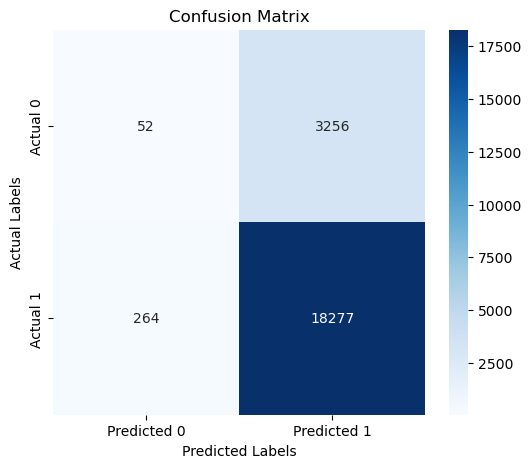

Classification Report:
              precision    recall  f1-score   support

         0.0       0.16      0.02      0.03      3308
         1.0       0.85      0.99      0.91     18541

    accuracy                           0.84     21849
   macro avg       0.51      0.50      0.47     21849
weighted avg       0.75      0.84      0.78     21849



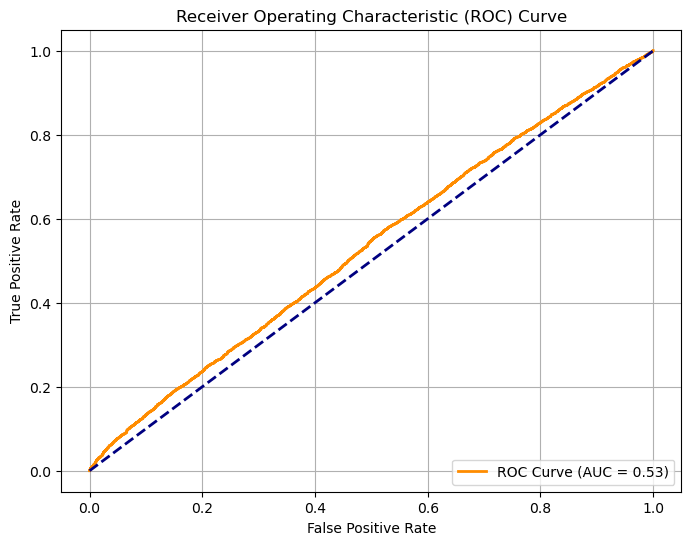

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

# Train the model with the best parameters
# best_params = {'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}

best_params = {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}


model = XGBClassifier(**best_params)
model.fit(X_resampled, y_resampled)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Confusion Matrix with Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()

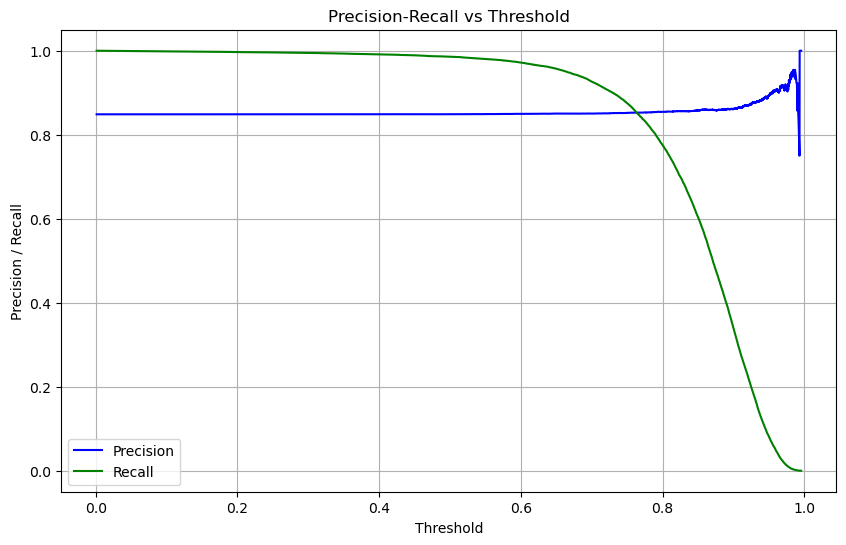


Threshold: 0.3
Confusion Matrix:
[[   20  3288]
 [   99 18442]]
False Positives: 3288
False Negatives: 99

Threshold: 0.5
Confusion Matrix:
[[   52  3256]
 [  264 18277]]
False Positives: 3256
False Negatives: 264

Threshold: 0.7
Confusion Matrix:
[[  284  3024]
 [ 1363 17178]]
False Positives: 3024
False Negatives: 1363

Threshold: 0.8
Confusion Matrix:
[[  862  2446]
 [ 4173 14368]]
False Positives: 2446
False Negatives: 4173


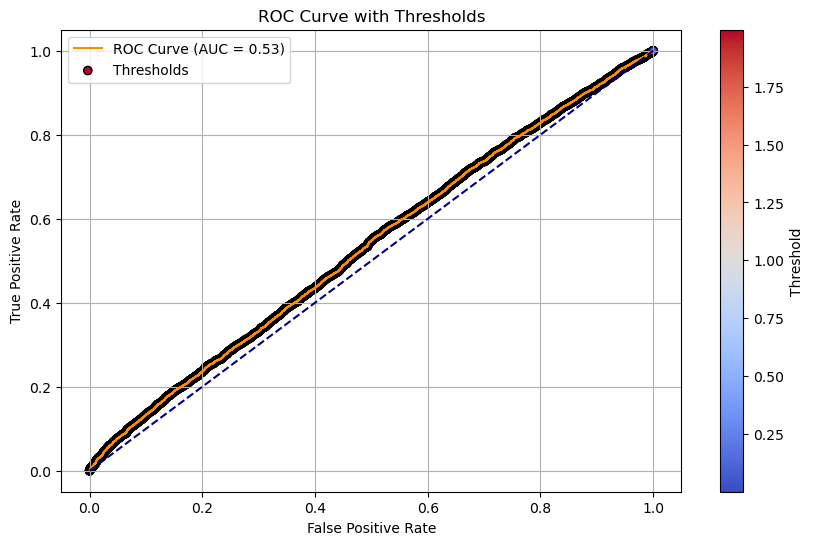

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

# Step 1: Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Step 2: Plot Precision-Recall vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="green")
plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.title("Precision-Recall vs Threshold")
plt.legend(loc="best")
plt.grid()
plt.show()

# Step 3: Evaluate Confusion Matrices for Different Thresholds
def evaluate_threshold(threshold):
    y_pred_threshold = (y_prob >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_threshold)
    print(f"\nThreshold: {threshold}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"False Positives: {conf_matrix[0, 1]}")
    print(f"False Negatives: {conf_matrix[1, 0]}")

# Example: Test thresholds
thresholds_to_test = [0.3, 0.5, 0.7, 0.8]
for thresh in thresholds_to_test:
    evaluate_threshold(thresh)

# Step 4: ROC Curve with Threshold Annotations
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.scatter(fpr, tpr, c=roc_thresholds, cmap="coolwarm", label="Thresholds", edgecolor='k')
plt.colorbar(label="Threshold")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Thresholds")
plt.legend(loc="best")
plt.grid()
plt.show()